This code can be used to download and plot the sea ice concentration data from NSIDC - note that they have two data products, the "NASA Team" and "Bootstrap" algorithm, which are considered similar in quality but may have different values.

Again, we start by importing a few modules.


In [32]:
import numpy as np
import datetime as dt
import struct, os
import subprocess as commands
from netCDF4 import Dataset
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib.path as mpath


Let's start by downloading a file. You can see a full list of files at https://n5eil01u.ecs.nsidc.org/PM/NSIDC-0079.003 - you can download just one to try it out by using wget, or you can use the '''parse_nsidc''' tool from the cryo-toolbox to do a bulk download! Here, we've just downloaded "bt_20181207_f17_v3.1_s.bin", which is included here for your convenience.

In [106]:
def get_data_nsidc(filename):
    year, month, day = int(filename[3:7]), int(filename[7:9]), int(filename[9:11])
    date = dt.date(year, month, day)
    with open(filename, 'rb') as icefile:
        contents = icefile.read()
    # unpack binary data into a flat tuple z
    source = filename[:2]
    if source=="nt": #nasa
        s="%dB" % (int(width*height),)
        z=struct.unpack_from(s, contents, offset = 300)#was 300
        nsidc = np.array(z).reshape((332,316))
        nsidcdata = np.rot90(nsidc, 2)/2.5
    elif source=="bt": #bootstrap
        with open(filename, 'rb') as icefile:
            contents = np.fromfile(icefile, dtype='<i2')
        nsidc = np.array(contents).reshape((332,316))
        nsidcdata = np.rot90(nsidc, 2)/12.
    else:
        print("please cd into the directory of the file. files should start with either bt_ or nt_")
    print("Loaded data from date {}".format(date))
    return nsidcdata, date


In [107]:
data, date = get_data_nsidc("bt_20181207_f17_v3.1_s.bin")

Loaded data from date 2018-12-07


Now we can plot the data - it's very straightforward. For the longitude/latitude grids, we will take them from U. Colorado, though you could also just make it yourself. However, these ones are from NSIDC directly.

In [108]:
def plot_map_nsidc(data, date):
    plt.clf()
    polar_crs = ccrs.SouthPolarStereo()
    plain_crs = ccrs.PlateCarree()
    polar_extent = [-180, 180, -90, -60]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1, projection=polar_crs)
    ax.axis('off')
    ax.set_extent(polar_extent, crs=plain_crs)
    ax.coastlines(resolution='50m', color='k')
    ax.gridlines(linestyle='--', draw_labels=True)
    #test if the lat/lon grid is downloaded yet, if not then download:
    if os.path.isfile("pss25lons_v3.dat")*os.path.isfile("pss25lats_v3.dat")==False:
        commands.getoutput("wget ftp://sidads.colorado.edu/pub/DATASETS/seaice/polar-stereo/tools/pss25lats_v3.dat") #get the lat/lon grid from NSIDC
        commands.getoutput("wget ftp://sidads.colorado.edu/pub/DATASETS/seaice/polar-stereo/tools/pss25lons_v3.dat") #get the lat/lon grid from NSIDC
        commands.getoutput("wget ftp://sidads.colorado.edu/pub/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat") #get the lat/lon grid from NSIDC
    with open("pss25lons_v3.dat", "rb") as file:
        lons  = np.fromfile(file, dtype= np.dtype("(332,316)i4"))[0]
        lons = np.rot90(lons, 2)/100000.
    with open("pss25lats_v3.dat", "rb") as file:
        lats  = np.fromfile(file, dtype= np.dtype("(332,316)i4"))[0]
        lats = np.rot90(lats,2)/100000.
    with open("pss25area_v3.dat", "rb") as file:
        areas  = np.fromfile(file, dtype= np.dtype("(332,316)i4"))[0]
        areas = np.rot90(areas,2)/1000.
    t = ax.pcolormesh(lons, lats, data, transform = ccrs.PlateCarree(), cmap='Blues_r')
    cbar = plt.colorbar(t, orientation="horizontal", fraction=.03, aspect=46, pad=.07)
    cbar.set_label("% ice cover")
    plt.title("Sea ice concentration on {}".format(date))
    return

<Figure size 432x288 with 0 Axes>

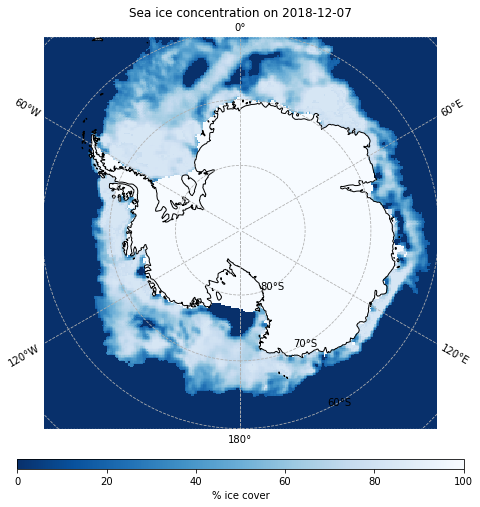

In [109]:
plot_map_nsidc(data, date)

Above you can see the sea ice concentration plotted. If you were wanting a more circular image for aesthetic reasons, it's an easy fix. Just set the values with latitude>-60 to be NaN.

<Figure size 432x288 with 0 Axes>

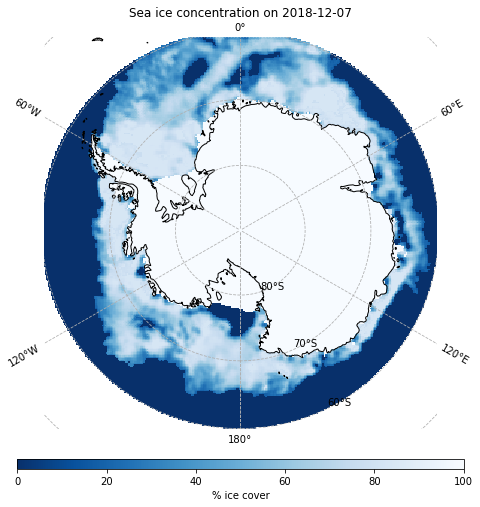

In [110]:
data[lats>-60] = np.nan
plot_map_nsidc(data, date)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
